In [ ]:
#| default_exp processing.coco

# COCO utilities

> Make coco annotations from shapefiles and transform predictions to shapefiles

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from drone_detector.imports import *
from drone_detector.utils import *
from drone_detector.processing.coordinates import *

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export
import datetime
from skimage import measure
from PIL import Image

## Binary masks to polygons

In [ ]:
#| export
# From https://github.com/waspinator/pycococreator/blob/master/pycococreatortools/pycococreatortools.py

def resize_binary_mask(array, new_size):
    image = Image.fromarray(array.astype(np.uint8)*255)
    image = image.resize(new_size)
    return np.asarray(image).astype(np.bool_)

def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

def binary_mask_to_polygon(binary_mask, tolerance=0):
    """Converts a binary mask to COCO polygon representation. Should probably be replaced with importing pycococreatortools instead.
    """
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation 
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons

## COCOProcessor

Utility to transform geospatial data to different COCO formats.

Notes:

* It is possible to specify `min_bbox_area` to `shp_to_coco` function to exclude too small polygons. Default value is 16 pixels
* If a detection is a multipart polygon, only the polygon with the largest area is converted to a shapefile.

In [ ]:
#| export

from pycocotools.mask import frPyObjects
from shapely.geometry import MultiPolygon

In [ ]:
#| export

def calc_bearing(point1, point2):
    "Get the angle of the rotated bounding box in radians"
    x1, y1 = point1
    x2, y2 = point2
    theta = math.atan2(y2 - y1, x2 - x1)
    theta = nor_theta(theta)
    return theta

def nor_theta(theta):
    "Convert angle to simpler format"
    if theta > math.radians(45):
        theta -= math.radians(90)
        theta = nor_theta(theta)
    elif theta <= math.radians(-45):
        theta += math.radians(90)
        theta = nor_theta(theta)
    return theta

In [ ]:
#| export

def _corners2rotatedbbox(poly):
    """Return rotated bounding box in (xc, yc, w, h, a) format used by detectron2 (xc, yc) is the center of the rotated box, a is the angle in degrees ccw"""
    centre = poly.centroid.coords.xy
    corners = np.array(poly.exterior.coords)
    theta = calc_bearing(corners[0], corners[1])
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta), np.cos(theta)]])
    out_points = np.matmul(corners - np.array(centre).T, rotation) + np.array(centre).T
    x, y = list(out_points[0,:])
    w, h = list(out_points[2, :] - out_points[0, :])
    return [centre[0][0], centre[1][0], np.abs(w), np.abs(h), -(theta*180)/np.pi] # Convert angle from radians to ccw degrees

    
def _process_shp_to_coco(image_id, category_id, ann_id, poly:Polygon, rotated_bbox:bool):
    "TODO handle multipolygons"
    ann_dict = {
        'segmentation': [],
        'area': None, 
        'bbox': [],
        'category_id': category_id,
        'id' : ann_id,
        'image_id': image_id,
        'iscrowd': 0,
    }

    if poly.type == 'Polygon':
        ann_dict['segmentation'] = [list(sum(poly.exterior.coords[:-1], ()))]
        if not rotated_bbox:
            ann_dict['bbox'] = [(poly.bounds[0]), 
                                (poly.bounds[1]), 
                                (poly.bounds[2]-poly.bounds[0]), 
                                (poly.bounds[3]-poly.bounds[1])]
        else: # XYWHA is the requirement for rotated bounding boxes
            ann_dict['bbox'] = _corners2rotatedbbox(poly.minimum_rotated_rectangle)
        ann_dict['area'] = poly.area
    elif poly.type == 'MultiPolygon':
        temp_poly = None
        max_area = 0
        # Take only the largest polygon
        for p in poly.geoms:
            area = p.area
            if area > max_area:
                max_area = area
                temp_poly = p
        ann_dict['segmentation'] = [list(sum(temp_poly.exterior.coords[:-1], ()))]
        if not rotated_bbox:
            ann_dict['bbox'] = [(temp_poly.bounds[0]), 
                                (temp_poly.bounds[1]), 
                                (temp_poly.bounds[2]-temp_poly.bounds[0]), 
                                (temp_poly.bounds[3]-temp_poly.bounds[1])]
        else:
            ann_dict['bbox'] = _corners2rotatedbbox(temp_poly.minimum_rotated_rectangle.exterior.coords)
        ann_dict['area'] = temp_poly.area
    return ann_dict


In [ ]:
#| export

class COCOProcessor():
    "Handles Transformations from shapefiles to COCO-format and backwards"
    
    def __init__(self, data_path:str, outpath:str, coco_info:dict, coco_licenses:list,
                 coco_categories:list):
        store_attr()
        self.raster_path = f'{self.data_path}/raster_tiles'
        self.vector_path = f'{self.data_path}/vector_tiles'
        self.prediction_path = f'{self.data_path}/predicted_vectors'
        
        self.coco_dict = {
            'info': coco_info,
            'licenses': coco_licenses,
            'images': [],
            'annotations': [],
            'categories': coco_categories,
            'segment_info': []
        }
        self.categories = {c['name']:c['id'] for c in self.coco_dict['categories']}
        
        
    def shp_to_coco(self, label_col:str='label', outfile:str='coco.json', min_bbox_area:int=16, 
                    rotated_bbox:bool=False):
        "Process shapefiles from self.vector_path to coco-format and save to self.outpath/outfile"
        vector_tiles = [f for f in os.listdir(self.vector_path) if f.endswith(('.shp', '.geojson'))]
        # If no annotations are in found in raster tile then there is no shapefile for that
        raster_tiles = [f'{fname.split(".")[0]}.tif' for fname in vector_tiles]
        ann_id = 1
        for i, r in tqdm(enumerate(raster_tiles)):
            tile_anns = []
            gdf = gpd.read_file(f'{self.vector_path}/{vector_tiles[i]}')
            tfmd_gdf = gdf_to_px(gdf, f'{self.raster_path}/{raster_tiles[i]}', precision=3)
            for row in tfmd_gdf.itertuples():
                category_id = self.categories[getattr(row, label_col)]
                if box(*row.geometry.bounds).area < min_bbox_area: continue # if bounding box is smaller than 4² pixels then exclude it
                tile_anns.append(_process_shp_to_coco(i, category_id, ann_id, row.geometry, rotated_bbox))
                ann_id += 1
            if len(tile_anns) > 0:
                with rio.open(f'{self.raster_path}/{r}') as im: 
                    h, w = im.shape
                self.coco_dict['images'].append({'file_name': raster_tiles[i],'id': i, 'height':h, 'width':w})
                self.coco_dict['annotations'].extend(tile_anns)

        with open(f'{self.outpath}/{outfile}', 'w') as f: json.dump(self.coco_dict, f)

        return
    
    def coco_to_shp(self, coco_data:dict=None, outdir:str='predicted_vectors', downsample_factor:int=1):
        """Generates shapefiles from a dictionary with coco annotations.
        TODO handle multipolygons better"""
        
        if not os.path.exists(f'{self.outpath}/{outdir}'): os.makedirs(f'{self.outpath}/{outdir}')
        
        annotations = coco_data['annotations']
        images = coco_data['images']
        categories = coco_data['categories']
        for i in tqdm(images):
            anns_in_image = [a for a in annotations if a['image_id'] == i['id']]
            if len(anns_in_image) == 0: continue
            cats = []
            polys = []
            scores = []
            for a in anns_in_image:
                # No segmentations, only bounding boxes
                if a['segmentation'] is None:
                    cats.append(a['category_id'])
                    if len(a['bbox']) == 4:
                        # Bbox has format xmin, ymin, xdelta, ydelta
                        polys.append(box(a['bbox'][0] / downsample_factor, 
                                         a['bbox'][1] / downsample_factor, 
                                         (a['bbox'][2] + a['bbox'][0]) / downsample_factor, 
                                         (a['bbox'][3]+a['bbox'][1]) / downsample_factor))
                    elif len(a['bbox']) == 5:
                        # Rotated bbox has format x_center, y_center, w, h, angle
                        xc = a['bbox'][0]
                        yc = a['bbox'][1]
                        w = a['bbox'][2]
                        h = a['bbox'][3]
                        angle = -np.radians(a['bbox'][4])
                        ax = xc + ((w/2)*np.cos(angle)) - ((h/2)*np.sin(angle))
                        ay = yc + ((w/2)*np.sin(angle)) + ((h/2)*np.cos(angle))

                        bx = xc - ((w/2)*np.cos(angle)) - ((h/2)*np.sin(angle))
                        by = yc - ((w/2)*np.sin(angle)) + ((h/2)*np.cos(angle))

                        cx = xc - ((w/2)*np.cos(angle)) + ((h/2)*np.sin(angle))
                        cy = yc - ((w/2)*np.sin(angle)) - ((h/2)*np.cos(angle))

                        dx = xc + ((w/2)*np.cos(angle)) + ((h/2)*np.sin(angle))
                        dy = yc + ((w/2)*np.sin(angle)) - ((h/2)*np.cos(angle))
                        polys.append(Polygon([(ax,ay), (bx,by), (cx,cy), (dx,dy)]))
                    if 'score' in a.keys():
                        scores.append(a['score'])
                # Single polygon
                elif len(a['segmentation']) == 1:
                    cats.append(a['category_id'])
                    xy_coords = [(a['segmentation'][0][i]  / downsample_factor, 
                                  a['segmentation'][0][i+1] / downsample_factor) 
                                 for i in range(0,len(a['segmentation'][0]),2)]
                    xy_coords.append(xy_coords[-1])
                    polys.append(Polygon(xy_coords))
                    if 'score' in a.keys():
                        scores.append(a['score'])
                # Multipolygon 
                else: 
                    temp_poly = None
                    max_area = 0
                    cats.append(a['category_id'])
                    for p in rangeof(a['segmentation']):
                        xy_coords = [(a['segmentation'][p][i] / downsample_factor, 
                                      a['segmentation'][p][i+1] / downsample_factor) 
                                     for i in range(0,len(a['segmentation'][p]),2)]
                        xy_coords.append(xy_coords[-1])
                        if Polygon(xy_coords).area > max_area:
                            temp_poly = Polygon(xy_coords)
                            max_area = temp_poly.area
                    polys.append(temp_poly)
                    if 'score' in a.keys():
                        scores.append(a['score'])
            gdf = gpd.GeoDataFrame({'label':cats, 'geometry':polys})
            if len(scores) != 0: gdf['score'] = scores
            tfmd_gdf = georegister_px_df(gdf, f'{self.raster_path}/{i["file_name"]}')
            tfmd_gdf.to_file(f'{self.outpath}/{outdir}/{i["file_name"][:-4]}.geojson', driver='GeoJSON')
        return

    def results_to_coco_res(self, label_col:str='label_id', outfile:str='coco_res.json'):
        result_tiles = [f for f in os.listdir(self.prediction_path) if f.endswith(('.shp', '.geojson'))]
        # If no annotations are in found in raster tile then there is no shapefile for that
        raster_tiles = [f'{fname.split(".")[0]}.tif' for fname in result_tiles]
        results = []
        for i in tqdm(rangeof(raster_tiles)):
            for im_id, im in enumerate(self.coco_dict['images']):
                if im['file_name'] == raster_tiles[i]:
                    break
            image_id = self.coco_dict['images'][im_id]['id']
            h = self.coco_dict['images'][im_id]['height']
            w = self.coco_dict['images'][im_id]['width']
            gdf = gpd.read_file(f'{self.prediction_path}/{result_tiles[i]}')
            tfmd_gdf = gdf_to_px(gdf, f'{self.raster_path}/{raster_tiles[i]}', precision=3)
            for row in tfmd_gdf.itertuples():
                res = {'image_id': image_id,
                       'category_id': getattr(row, label_col),
                       'segmentation': None,
                       'score': np.round(getattr(row, 'score'), 5)}
                ann = _process_shp_to_coco(image_id, getattr(row, label_col), 0, row.geometry)
                res['segmentation'] = frPyObjects(ann['segmentation'], h, w)[0]
                res['segmentation']['counts'] = res['segmentation']['counts'].decode('ascii')
                results.append(res)
        
        with open(f'{self.outpath}/{outfile}', 'w') as f: 
            json.dump(results, f)

def _corners2rotatedbbox(poly):
    """Return rotated bounding box in (xc, yc, w, h, a) format used by detectron2
    (xc, yc) is the center of the rotated box, a is the angle in degrees ccw"""
    centre = poly.centroid.coords.xy
    corners = np.array(poly.exterior.coords)
    theta = calc_bearing(corners[0], corners[1])
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta), np.cos(theta)]])
    out_points = np.matmul(corners - np.array(centre).T, rotation) + np.array(centre).T
    x, y = list(out_points[0,:])
    w, h = list(out_points[2, :] - out_points[0, :])
    return [centre[0][0], centre[1][0], np.abs(w), np.abs(h), -(theta*180)/np.pi] # Convert angle from radians to ccw degrees

In [ ]:
#| hide

def icevision_mask_preds_to_coco_anns(preds:list) -> dict:
    """Process list of IceVision `samples` and `preds` to COCO-annotation polygon format. 
    Returns a dict with Coco-style `images` and `annotations`
    
    TODO replace these with functions from icevision somehow"""
    outdict = {}
    outdict['annotations'] = []
    outdict['images'] = [{'file_name': str(f'{p.ground_truth.filepath.stem}{p.ground_truth.filepath.suffix}'), 'id': p.record_id} for p in preds]
    anns = []
    for i, p in tqdm(enumerate(preds)): 
        for j in rangeof(p.pred.detection.label_ids):
            anns = []
            ann_dict = {
                'segmentation': binary_mask_to_polygon(p.pred.detection.mask_array.to_mask(p.height,p.width).data[j]),
                'area': None,  
                'iscrowd': 0,
                'category_id': p.pred.detection.label_ids[j].item(),
                'id': i,
                'image_id': p.record_id,
                'bbox': [p.pred.detection.bboxes[j].xmin.item(), 
                         p.pred.detection.bboxes[j].ymin.item(),
                         p.pred.detection.bboxes[j].xmax.item() - p.pred.detection.bboxes[j].xmin.item(),
                         p.pred.detection.bboxes[j].ymax.item() - p.pred.detection.bboxes[j].ymin.item()],
                'score': p.pred.detection.scores[j]
            }

            if len(ann_dict['segmentation']) == 0:
                # Quickhack, find reason for empty annotation masks later
                continue
            anns.append(ann_dict)
            outdict['annotations'].extend(anns)

    return outdict

def icevision_bbox_preds_to_coco_anns(preds:list) -> dict:
    """Process list of IceVision `samples` and `preds` to COCO-annotation polygon format. 
    Returns a dict with Coco-style `images` and `annotations`"""
    outdict = {}
    outdict['annotations'] = []
    outdict['images'] = [{'file_name': str(f'{p.ground_truth.filepath.stem}{p.ground_truth.filepath.suffix}'), 'id': p.record_id} for p in preds]

    anns = []
    for i, p in tqdm(enumerate(preds)): 
        for j in rangeof(p.pred.detection.bboxes):
            anns = []
            ann_dict = {
                'segmentation': None,
                'area': None,  
                'iscrowd': 0,
                'category_id': p.pred.detection.label_ids[j].item(),
                'id': i,
                'image_id': p.record_id,
                'bbox': [p.pred.detection.bboxes[j].xmin.item(), 
                         p.pred.detection.bboxes[j].ymin.item(),
                         p.pred.detection.bboxes[j].xmax.item() - p.pred.detection.bboxes[j].xmin.item(),
                         p.pred.detection.bboxes[j].ymax.item() - p.pred.detection.bboxes[j].ymin.item()],
                'score': p.pred.detection.scores[j]
            }

            anns.append(ann_dict)
            outdict['annotations'].extend(anns)

    return outdict



In [ ]:
#| export
from detectron2.structures.rotated_boxes import RotatedBoxes

In [ ]:
#| export

def detectron2_bbox_preds_to_coco_anns(images:list, preds:list) -> dict:
    """Process detectron2 prediction to COCO-annotation polygon format. Returns a dict with COCO-style `images` and `annotations`
    """
    outdict = {}
    outdict['annotations'] = []
    outdict['images'] = images

    for i in tqdm(rangeof(preds)):
        p = preds[i]['instances']
        for j in rangeof(p.pred_classes):
            anns = []
            ann_dict = {
                'segmentation': None,
                'area': None,  
                'iscrowd': 0,
                'category_id': p.pred_classes[j].item(),
                'id': i+1,
                'image_id': images[i]['id'],
                'score': p.scores[j].item()
            }
            if isinstance(p.pred_boxes[j], RotatedBoxes): #xywha_abs
                ann_dict['bbox'] = [p.pred_boxes[j].tensor[0,0].item(),
                                    p.pred_boxes[j].tensor[0,1].item(),
                                    p.pred_boxes[j].tensor[0,2].item(),
                                    p.pred_boxes[j].tensor[0,3].item(),
                                    p.pred_boxes[j].tensor[0,4].item()]
            else: # xyxy_abs -> xywh_abs
                ann_dict['bbox'] = [p.pred_boxes[j].tensor[0,0].item(), 
                                    p.pred_boxes[j].tensor[0,1].item(),
                                    p.pred_boxes[j].tensor[0,2].item() - p.pred_boxes[j].tensor[0,0].item(),
                                    p.pred_boxes[j].tensor[0,3].item() - p.pred_boxes[j].tensor[0,1].item()]
            anns.append(ann_dict)
            outdict['annotations'].extend(anns)

    return outdict


def detectron2_mask_preds_to_coco_anns(images:list, preds:list) -> dict:
    """Process detectron2 prediction to COCO-annotation polygon format. Returns a dict with COCO-style `images` and `annotations`
    """
    outdict = {}
    outdict['annotations'] = []
    outdict['images'] = images

    for i in tqdm(rangeof(preds)):
        p = preds[i]['instances']
        for j in rangeof(p.pred_classes):
            anns = []
            ann_dict = {
                'segmentation': binary_mask_to_polygon(p.pred_masks[j].cpu().numpy()),
                'area': None,  
                'iscrowd': 0,
                'category_id': p.pred_classes[j].item(),
                'id': i+1,
                'image_id': images[i]['id'],
                'bbox': [p.pred_boxes[j].tensor[0,0].item(), 
                         p.pred_boxes[j].tensor[0,1].item(),
                         p.pred_boxes[j].tensor[0,2].item() - p.pred_boxes[j].tensor[0,0].item(),
                         p.pred_boxes[j].tensor[0,3].item() - p.pred_boxes[j].tensor[0,1].item()],
                'score': p.scores[j].item()
            }
            if len(ann_dict['segmentation']) == 0:
                # Quickhack, find reason for empty annotation masks later
                continue
            anns.append(ann_dict)
            outdict['annotations'].extend(anns)

    return outdict

After tiling the data, `COCOProcessor` can be used to convert it into a coco style dataset. You need to manually set the coco-info, categories and licenses.

In [ ]:
deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'Standing'},
        {'supercategory':'deadwood', 'id':2, 'name': 'Fallen'},
    ]

from datetime import date

coco_info = {'description': 'dummydataset for example purposes',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}


Base version with raw original bounding boxes.

In [ ]:
outpath = Path('example_data/tiles/')
coco_proc = COCOProcessor(outpath, outpath, coco_info, coco_licenses, deadwood_categories)
coco_proc.shp_to_coco('label', outfile='coco_norm.json', rotated_bbox=False)

13it [00:00, 45.76it/s]


You can also do rotated bounding boxes.

In [ ]:
outpath = Path('example_data/tiles/')
coco_proc = COCOProcessor(outpath, outpath, coco_info, coco_licenses, deadwood_categories)
coco_proc.shp_to_coco('label', outfile='coco_rot.json', rotated_bbox=True)

13it [00:00, 45.91it/s]


Use detectron2 to visualize the differences.

In [ ]:
#| examples
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, DatasetMapper
import random
import cv2


In [ ]:
#| examples

outpath = Path('example_data/tiles/')

register_coco_instances('dummy_norm', {}, outpath/'coco_norm.json', outpath/'raster_tiles')
register_coco_instances('dummy_rot', {}, outpath/'coco_rot.json', outpath/'raster_tiles')

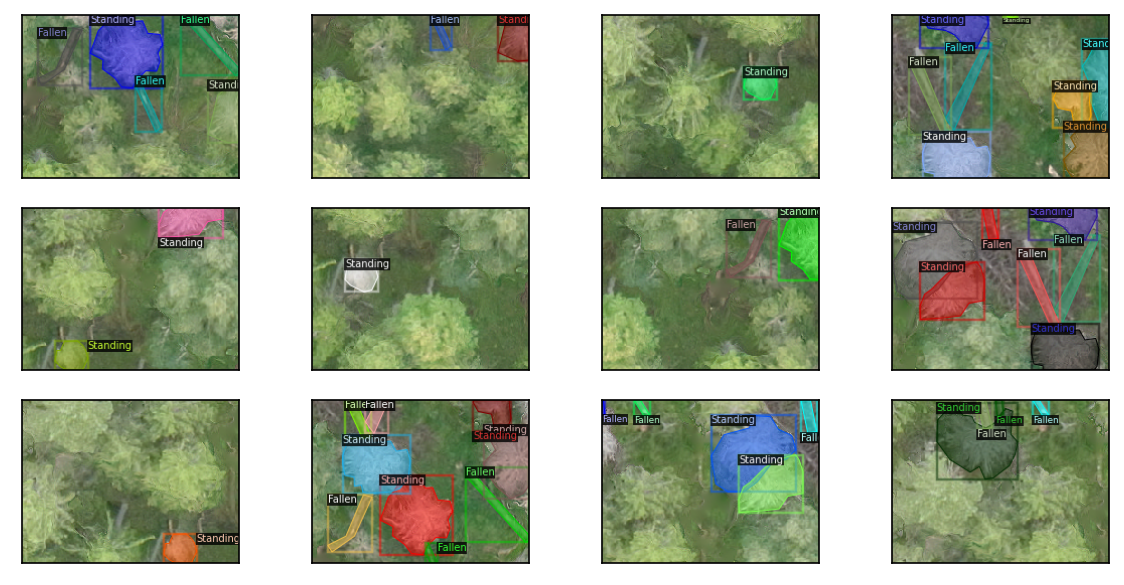

In [ ]:
#| examples

fig, axs = plt.subplots(3,4, figsize=(8,4), dpi=150)
metadata = MetadataCatalog.get('dummy_norm')
dataset_dicts = DatasetCatalog.get('dummy_norm')
ddicts = dataset_dicts[:12]
for d, ax in zip(ddicts, axs.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img, metadata=metadata, scale=0.9)
    truth = visualizer.draw_dataset_dict(d)
    
    ax.imshow(truth.get_image()[...,::-1])
plt.tight_layout()

detectron2 doesn't yet support masks and rotated bounding boxes at the same time.

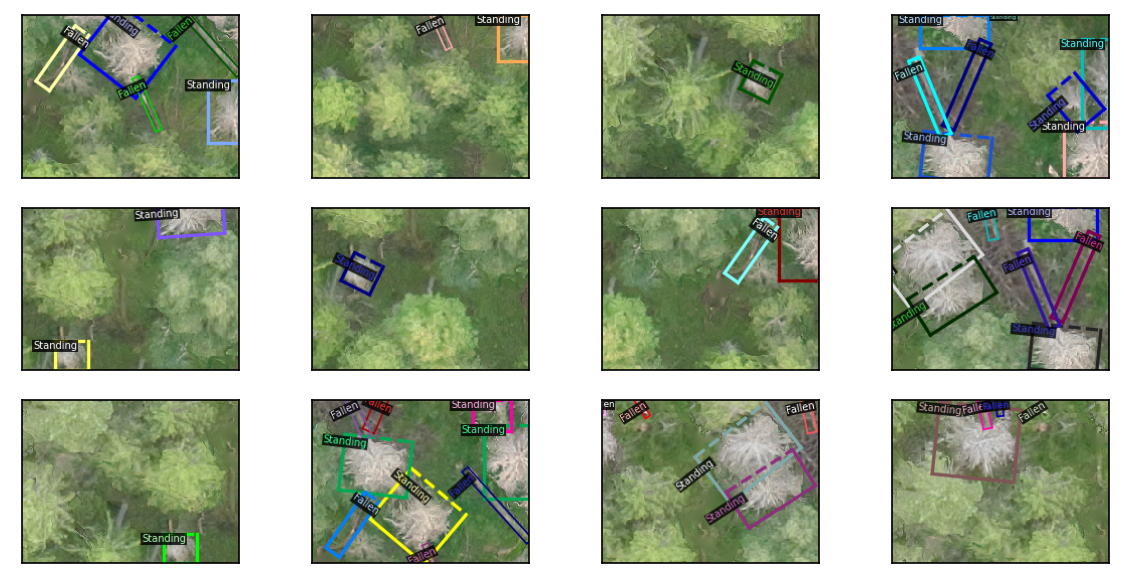

In [ ]:
#| examples

fig, axs = plt.subplots(3,4, figsize=(8,4), dpi=150)
metadata = MetadataCatalog.get('dummy_rot')
dataset_dicts = DatasetCatalog.get('dummy_rot')
ddicts = dataset_dicts[0:12]
for d, ax in zip(ddicts, axs.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img, metadata=metadata, scale=0.9)
    truth = visualizer.draw_dataset_dict(d)
    
    ax.imshow(truth.get_image()[...,::-1])
plt.tight_layout()

In [ ]:
#| hide

from nbdev import nbdev_export
nbdev_export()